## All graphs dealing w/any billing data are broken!
0. be sure to run this notebook in the notebook/ directory!
1. session length - general stats on how long sessions are. means,
percentiles, etc.
2. User 'profile' - how many 'kinds' of users do we have? Some who
just pop in once? Some who pop in a few times a week for a fixed
amount of time? some who are there all the time? what kinda user
clusters do we have?
3. Who are those people using it 400 times in a semester?
4. are there user corelations? Can we spot 'groups' of users with
similar behavior? What kinda behavior is it? etc

In [15]:
import pandas as pd
import numpy as np
from datetime import datetime
import altair as alt
from IPython import display

In [16]:
# Set the altair theme
def my_theme(*args, **kwargs):
    return {'config': {'axis': {'labelFontSize': 20, 'titleFontSize': 20}}}
alt.themes.register('my-chart', my_theme)
alt.themes.enable('my-chart')

ThemeRegistry.enable('my-chart')

# Params and functions

In [17]:
semester_start = pd.Timestamp('2023-01-10').tz_localize('US/Pacific')
semester_end = pd.Timestamp('2023-05-12').tz_localize('US/Pacific')

In [18]:
def convert_tz(series):
    series = series.dt.tz_localize('UTC')
    return series.dt.tz_convert('US/Pacific')

# Load data

## User session data

In [19]:
# Log data for user activity
path_sessions = '../data/processed/spring-2023/user-sessions.jsonl'
sessions = pd.read_json(path_sessions, convert_dates=['start', 'stop'])

for col in ['start', 'stop']:
    sessions[col] = convert_tz(sessions[col])

In [20]:
print(len(sessions))
# Only between start and end of semester
sessions = sessions[sessions['start'] > semester_start][sessions['start'] < semester_end]
print(len(sessions))

263833
261231


/tmp/ipykernel_11091/3046363681.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sessions = sessions[sessions['start'] > semester_start][sessions['start'] < semester_end]


## BROKEN -- Cost per day

In [ ]:
cost = pd.read_json('../data/processed/fall-2018/cloud-costs.jsonl', lines=True)
cost['start_time'] = convert_tz(cost['start_time'])
cost = cost.drop(columns=['end_time']).set_index('start_time')

In [ ]:
# Only between start and end of semester
cost = cost[cost.index > semester_start][cost.index < semester_end]
# We only use indexing timestamps to make the tz_localize easier.
# after that, we drop it to make everything else easier
cost = cost.reset_index()

# Fill in any missing data before beginning of date
missing_dates = pd.date_range(semester_start, cost.start_time.min(), name='start_time')
missing_dates_cost = pd.DataFrame(missing_dates, np.full(len(missing_dates), np.nan), columns={'start_time', 'cost'})
cost = cost.append(missing_dates_cost)

# Viz and analysis

## Daily Active user

We count someone as a 'daily active user' if they start / stop their notebook server
at least once. Due to anonimization techniques applied earlier, this might slightly
under count users

In [21]:
# Unique daily users - we count anyone who has logged in at least once a day
# We want a dataframe with no index so we can use it easily with Altair
daily_active_users = pd.DataFrame(sessions.set_index('start')['user'].resample('D').nunique()).reset_index()

In [22]:
alt.Chart(daily_active_users, width=900).mark_line().encode(
    x='start',
    y='user'
)

alt.Chart(...)

In [23]:
# daily active users stats
mean_daily_active_users = daily_active_users['user'].mean()
max_daily_active_users = daily_active_users['user'].max()
min_daily_active_users = daily_active_users['user'].min()
display.HTML(f'<h3>Daily active users: </h3><b>Mean -- max -- min</b><br>{mean_daily_active_users: .2f} -- {max_daily_active_users: .2f} -- {min_daily_active_users: .2f}') 

## BROKEN -- Daily cloud costs

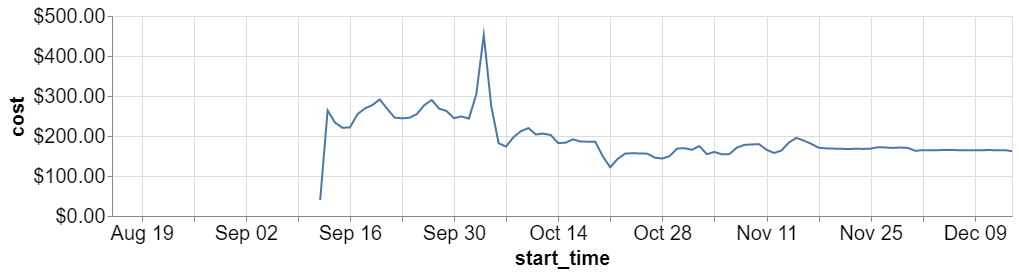

In [12]:
alt.Chart(cost, width=900).mark_line().encode(
    x='start_time',
    y=alt.Y('cost', axis=alt.Axis(format="$.2f"))
)

In [13]:
# Mean daily active users
mean_cost = cost['cost'].mean()
display.HTML(f'<h3>Mean daily cloud cost: <b>${mean_cost: .2f}</b></h3>')

## Daily cloud costs per **active** user

This is cost per day for *active* users - those who used the cluster. This is only a fraction of your total users, so be careful using this for estimates.

In [14]:
# Combine into a single dataframe based on day
total = pd.merge(daily_active_users, cost, how='outer', left_on='start', right_on='start_time').drop(columns=['start_time'])

# Calculate daily cost per user
total['cost_per_active_user'] = total['cost'] / total['user']

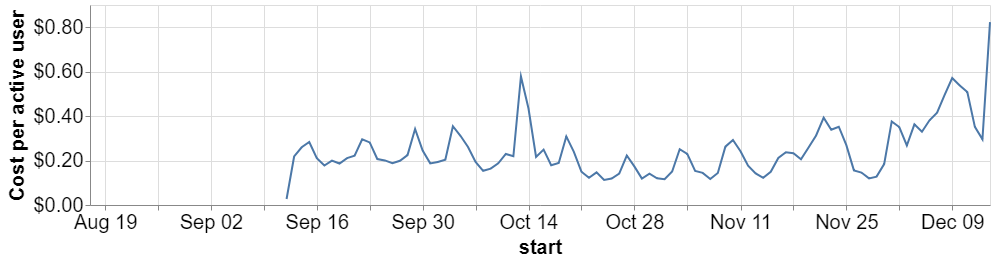

In [15]:
alt.Chart(total, width=900).mark_line().encode(
    x='start',
    y=alt.Y('cost_per_active_user', axis=alt.Axis(format="$.2f"), title="Cost per active user")
)

## Total Users

One way to count the 'number of users on the JupyterHub' is to look at everyone who has ever started a notebook. Since anyone with a Berkeley.edu account can log in, this is not the most accurate count of people who *use* the hub - but it's useful nonetheless.

In [24]:
user_starts_count = sessions.groupby('user').count()['start'].to_frame()
display.HTML(f'<h4>Users who used JupyterHub at least once: <b>{user_starts_count.shape[0]}</b></h4>')

Some basic stats about number of times users started their servers

In [25]:
user_starts_count.describe()

,start
count,12257.000000
mean,21.312801
std,21.201713
min,1.000000
25%,3.000000
50%,15.000000
75%,34.000000
max,193.000000


BROKEN -- We can calculate cost per day per user from this user count

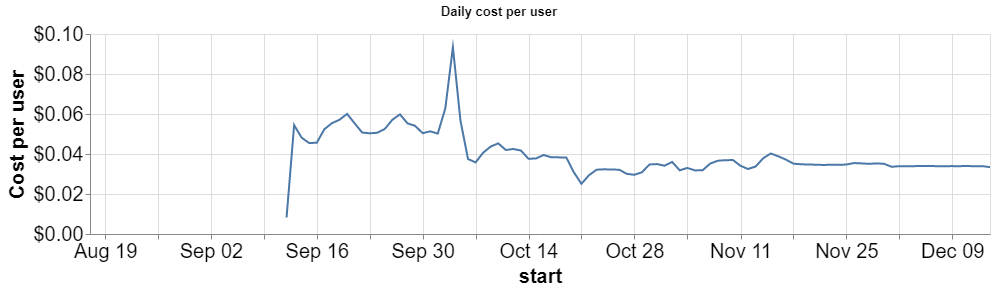

In [18]:
total['cost_per_user'] = total['cost'] / user_starts_count.count()['start']

alt.Chart(total, width=900, title='Daily cost per user').mark_line().encode(
    x='start',
    y=alt.Y('cost_per_user', axis=alt.Axis(format="$.2f"), title="Cost per user")
)

We can also figure out how much they cost per month.

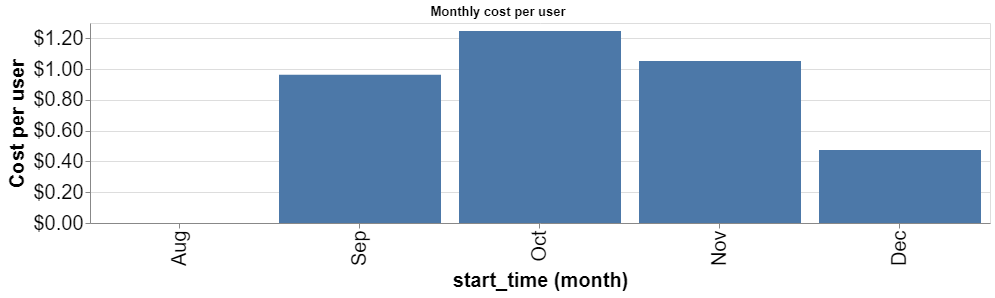

In [19]:
monthly = cost.copy().set_index('start_time').resample('M').sum()
monthly['cost_per_user'] = monthly['cost'] / user_starts_count.count()['start']
monthly = monthly.reset_index()

alt.Chart(monthly, width=900, title='Monthly cost per user').mark_bar().encode(
    x='month(start_time):O',
    y=alt.Y('cost_per_user', axis=alt.Axis(format="$.2f"), title="Cost per user")
)

## BROKEN -- Realistic user count

A lot of people might log in a few times to the JupyterHub to check it out, and then never really come back. We should avoid counting those as 'users' when doing our cost analysis. 

We can cut off outliers at the 99th percentile and plot a histogram to see how most people use the hub

In [ ]:
outlier_cutoff = user_starts_count.quantile(0.99)
alt.Chart(user_starts_count[user_starts_count['start'] < outlier_cutoff['start']], width=900).mark_bar().encode(
    alt.X('start', bin=alt.BinParams(maxbins=100)),
    y='count()'
)

There's a lot of users who use the hub <5 times, and many who use it 5-10 times. We pick an arbitrary cut off of 'ten notebook server starts' to count as a 'real' user and not someone just trying out the hub.

In [26]:
users_with_more_than_ten_starts = user_starts_count[user_starts_count['start'] > 10]
display.HTML(f'<h4>Users who used the hub more than 10 times: <b>{users_with_more_than_ten_starts.count()["start"]}')

We can use this to plot a daily and monthly cost per user

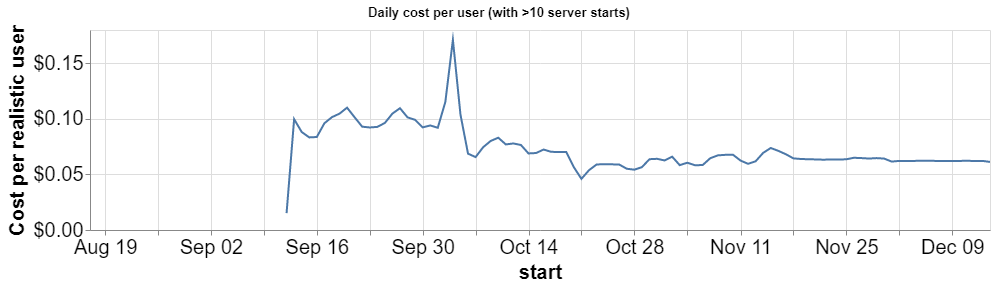

In [22]:
total['cost_per_realistic_user'] = total['cost'] / users_with_more_than_ten_starts.count()['start']

alt.Chart(total, width=900, title='Daily cost per user (with >10 server starts)').mark_line().encode(
    x='start',
    y=alt.Y('cost_per_realistic_user', axis=alt.Axis(format="$.2f"), title="Cost per realistic user")
)

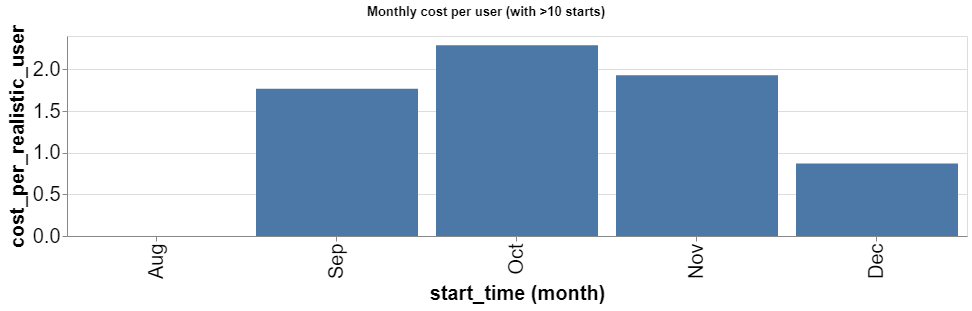

In [23]:
realistic_monthly = cost.copy().set_index('start_time').resample('M').sum()
realistic_monthly['cost_per_realistic_user'] = realistic_monthly['cost'] / users_with_more_than_ten_starts.count()['start']
realistic_monthly = realistic_monthly.reset_index()

alt.Chart(realistic_monthly, width=900, title='Monthly cost per user (with >10 starts)').mark_bar().encode(
    x='month(start_time):O',
    y='cost_per_realistic_user'
)

## Session length

In [27]:
length_counts = sessions.groupby('length_hours').count().reset_index()
alt.Chart(length_counts, width=300).mark_bar().encode(
    x='length_hours',
    y=alt.Y('start', title="Count")
)

alt.Chart(...)

# Summary

Mean number of daily active users per day: **1783**

Monthly cost per 'realistic' user: **~2$**  <--- needs to be updated!